## Import packages and data

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
# knn imputer
from sklearn.impute import KNNImputer
import itertools

#randum under sampling
from imblearn.under_sampling import RandomUnderSampler

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#model metrics
from sklearn.metrics import classification_report, make_scorer, roc_auc_score, log_loss
from sklearn.model_selection import cross_val_score

roc_auc_scorer = make_scorer(
    roc_auc_score, 
    greater_is_better=True,
    needs_threshold=True, 
    average=None
)

log_losser = make_scorer(
    log_loss, 
    greater_is_better=False, 
    needs_proba=True
) 

# feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [6]:
data = pd.read_excel('./data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

## Exploratory Data Analysis

### Univariate analysis

In [ ]:
data

In [3]:
data.head(5)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


On first overview of the data:
- Categorical variables are mostly one-hot encoded already. The exception is `AGE_PERCENTIL` and `WINDOW`. 
- The numeric variables are min-max scaled.
- There are 384 unique people identifiers.
- There are 5 missing values from disease groupings.
- Blood metrics have 1104 common missing values.
- Other biometrics have various missing values ranging from 685 to 748
- There are no missing values for `PATIENT_VISIT_IDENTIFIER`, `AGE_ABOVE65`, `AGE_PERCENTIL`, `GENDER`, `WINDOW`, and `ICU` (the target)


#### Target feature

The data maintainers indicated that time windows leading up to ICU care, not during or after ICU care, should be used during modeling.

Each person has 5 rows, a row for each `WINDOW` time.

##### Distribution plots

<AxesSubplot: xlabel='PATIENT_VISIT_IDENTIFIER', ylabel='Count'>

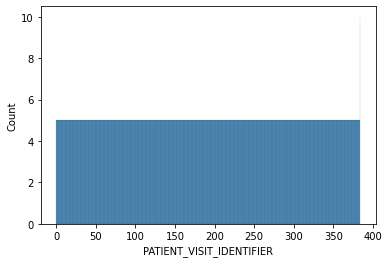

In [38]:
sns.histplot(data, x='PATIENT_VISIT_IDENTIFIER', binwidth=1)

There are three possibilities for ICU care:
- the person was admitted straight to ICU (`1_1`, see the bar graph below)
- the person was transported to ICU (`2_1`)
- the person was never in ICU (`1_0`)

In [8]:
target_df = data[['PATIENT_VISIT_IDENTIFIER', 'ICU']].groupby('PATIENT_VISIT_IDENTIFIER').nunique().rename(columns={'ICU': 'loc'}).merge(
    data[data['WINDOW'] == '0-2'][['PATIENT_VISIT_IDENTIFIER', 'ICU']].rename(columns={'ICU': 'Init'}),
    on='PATIENT_VISIT_IDENTIFIER'
)

target_df = target_df.assign(
    lab = target_df['loc'].astype(str) + '_' + target_df['Init'].astype(str),
)

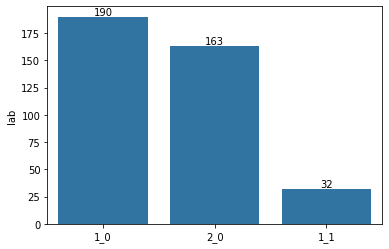

In [39]:
plot = sns.barplot(data=target_df['lab'].value_counts())

plot.bar_label(plot.containers[0]);

There are about 30 people that went straight to ICU. 
This data cannot be used in the modeling.

There are ~180 people that never went to ICU care.
These are the negative values for modeling.

There are ~160 people that transitioned to ICU care.
These are the positive values for modeling.

While the remaining people are somewhat balanced (180 to 160), we will have 5 time window values for the negatives (180x5 values [900]) and intermediate windows for the positives (ranging from 1x160 to 4x160 values [160-640]). 
That means the target is imbalanced towards negative values.
This might result in default models making better predictions for negative cases.
I think random undersampling of the negative values would be a good approach to handle the imbalance.

When were people transported to ICU?

In [13]:
window_counts = target_df[target_df['lab'] == '2_0'][['PATIENT_VISIT_IDENTIFIER', 'lab']]\
    .merge(
        data[['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'ICU']],
        on='PATIENT_VISIT_IDENTIFIER'
    )\
    .drop(columns=['PATIENT_VISIT_IDENTIFIER', 'lab'])\
    .groupby('WINDOW')\
    .sum()

window_counts = window_counts.reset_index()

In [14]:
window_counts['ICU'].iloc[0] = 32
window_counts['ICU'].iloc[2] =\
    window_counts['ICU'].iloc[2] - window_counts['ICU'].iloc[1]
window_counts['ICU'].iloc[3] =\
    window_counts['ICU'].iloc[3] - (window_counts['ICU'].iloc[2] + window_counts['ICU'].iloc[1])
window_counts['ICU'].iloc[4] =\
    window_counts['ICU'].iloc[4] - (window_counts['ICU'].iloc[3] + window_counts['ICU'].iloc[2] + window_counts['ICU'].iloc[1])

C:\Users\barne\AppData\Local\Temp\ipykernel_32540\55780615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_counts['ICU'].iloc[0] = 32
C:\Users\barne\AppData\Local\Temp\ipykernel_32540\55780615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_counts['ICU'].iloc[2] =\
C:\Users\barne\AppData\Local\Temp\ipykernel_32540\55780615.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_counts['ICU'].iloc[3] =\
C:\Users

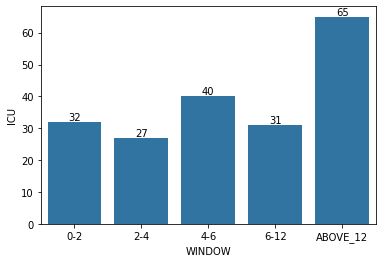

In [15]:
plot = sns.barplot(data=window_counts, x='WINDOW', y='ICU')
plot.bar_label(plot.containers[0]);

The highest amount of people, in any given window, were moved to ICU after 12 hrs in the hospital.

##### Modeling decision: recode the target

In [19]:
data2 = data.copy()

data2 = data2[data2['ICU'] != 1]

data2 = data2.merge(
    target_df[['PATIENT_VISIT_IDENTIFIER', 'lab']],
    on='PATIENT_VISIT_IDENTIFIER'
).rename(columns={'lab': 'target'})

data2['target'] = np.where(data2['target'] == '1_0', 0, 1)
data2.drop(columns=['WINDOW', 'ICU'], inplace=True)

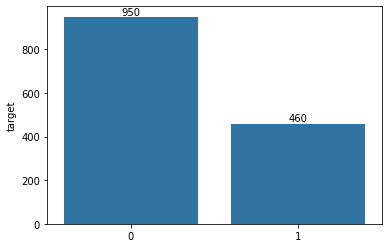

In [44]:
plot = sns.barplot(data=data2['target'].value_counts())
plot.bar_label(plot.containers[0]);

The target values for modelling have 950 negatives and 460 positives.

I plan to use random undersampling to balance the target for modeling.

#### Numeric features

In [6]:
# names of numeric features for plotting
num_data = data[data.columns[data.nunique() > 2]]
num_data = num_data[num_data.columns[num_data.dtypes != 'O']]
num_cols = num_data.columns
del num_data

##### Distribution plots

The data is reporting multiple stat features per unique measurement. 
I want to explore the relevance of those stat types for "information gain"* wrt the measurement.
- *does the choice of stat change the overall distribution for the measurement?

I will use this information later to remove redundant features.

In [7]:
unique_names = pd.Series(list(set(['_'.join(x[:-1]) for x in num_cols.str.split(pat='[_]')[1:]])))
unique_names[~unique_names.str.contains('DIFF')]

biometrics = pd.Series([x[:-5] for x in unique_names[unique_names.str.contains('DIFF')]])

biomarkers = pd.merge(
    unique_names[~unique_names.str.contains('DIFF')].rename('name'), 
    biometrics.rename('name'), 
    how='outer', 
    indicator=True
    )
biomarkers = biomarkers[biomarkers['_merge'] == 'left_only'].drop(columns='_merge')

Separating numeric features by measurement type, blood biomarker or vital biometric.

In [6]:
biomarkers_df = pd.DataFrame()

for i in biomarkers['name']:
    subs_df = data[data.columns[data.columns.str.contains(i)]]
    biomarkers_df = pd.concat([biomarkers_df, subs_df], axis=1)

In [7]:
biometrics_df = pd.DataFrame()

for i in biometrics:
    subs_df = data[data.columns[data.columns.str.contains(i)]]
    biometrics_df = pd.concat([biometrics_df, subs_df], axis=1)

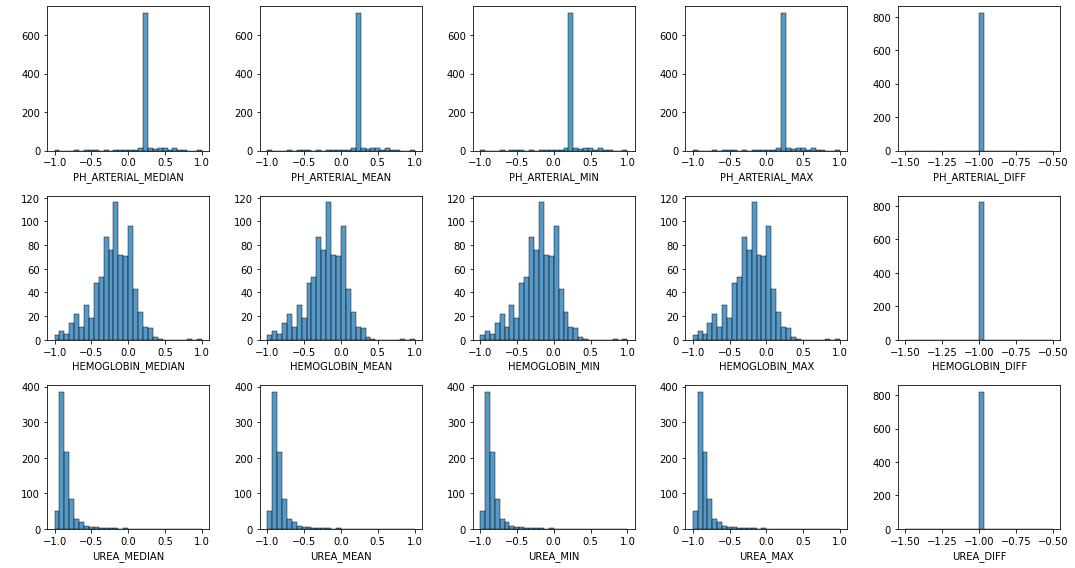

In [181]:
fig, axes = plt.subplots(3, 5, figsize=(15, 8))

for i in range(0, axes.flatten().shape[0]):
    sns.histplot(data=biomarkers_df, x=biomarkers_df.columns[i], bins=30, ax=axes.flatten()[i])
    axes.flatten()[i].set_ylabel(' ')

plt.tight_layout()

In [81]:
diff_df = biomarkers_df[biomarkers_df.columns[biomarkers_df.columns.str.contains('DIFF')]]

np.alltrue([diff_df[x].value_counts().count() < 2 for x in diff_df.columns])

True

`DIFF` features do not have parameter space, all values are the same (-1). 
I think that is because there are no repeated measures for these features.
`MEDIAN`, `MEAN`, `MIN`, and `MAX` appear to have the same information. 
We can just focus on one stat per measurement for an overview of distributions.

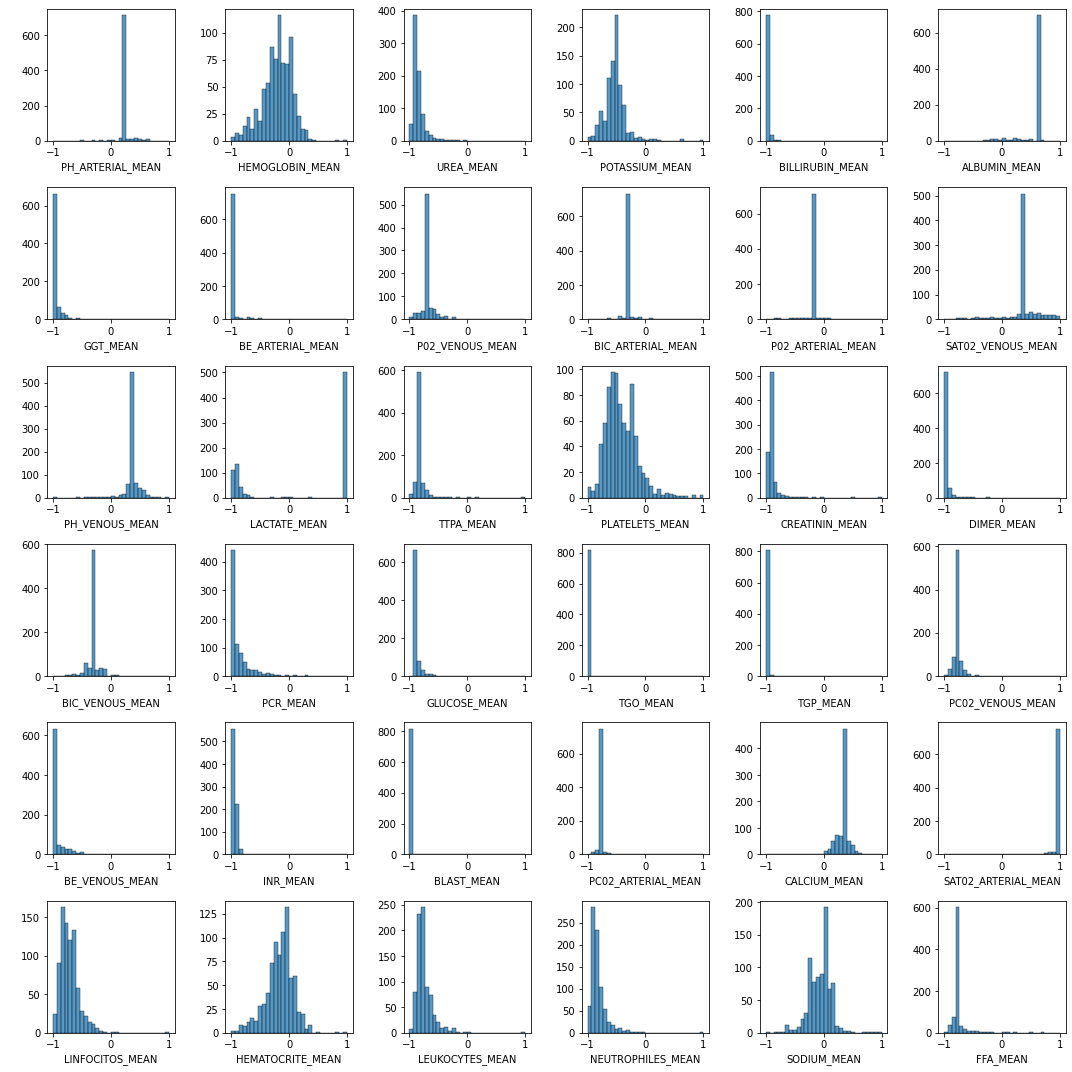

In [183]:
fig, axes = plt.subplots(6, 6, figsize=(15, 15))

mean_biomar_df = biomarkers_df[biomarkers_df.columns[biomarkers_df.columns.str.contains('MEAN')]]

for i in range(0, axes.flatten().shape[0]):
    sns.histplot(data=mean_biomar_df, x=mean_biomar_df.columns[i], bins=30, ax=axes.flatten()[i])
    axes.flatten()[i].set_ylabel(' ')

plt.tight_layout()

The distributions are scaled (-1, 1) but not zero centered. 
`HEMOGLOBIN`, `POTASSIUM`, `PLATELETS`, `LINFOCITOS`, `HEMATOCRITE`, `LEUKOCYTES`, `NEUTROPHILES`, and `SODIUM` are more distributed in parameter space and would have less kurtosis compared to the other distributions that have strong peaks. 
`LACTATE` values look bimodal. `HEMATOCRITE`, `SODIUM`, and `HEMOGLOBIN` appear gaussian. 
The other named distributions have a right skew to positive values.

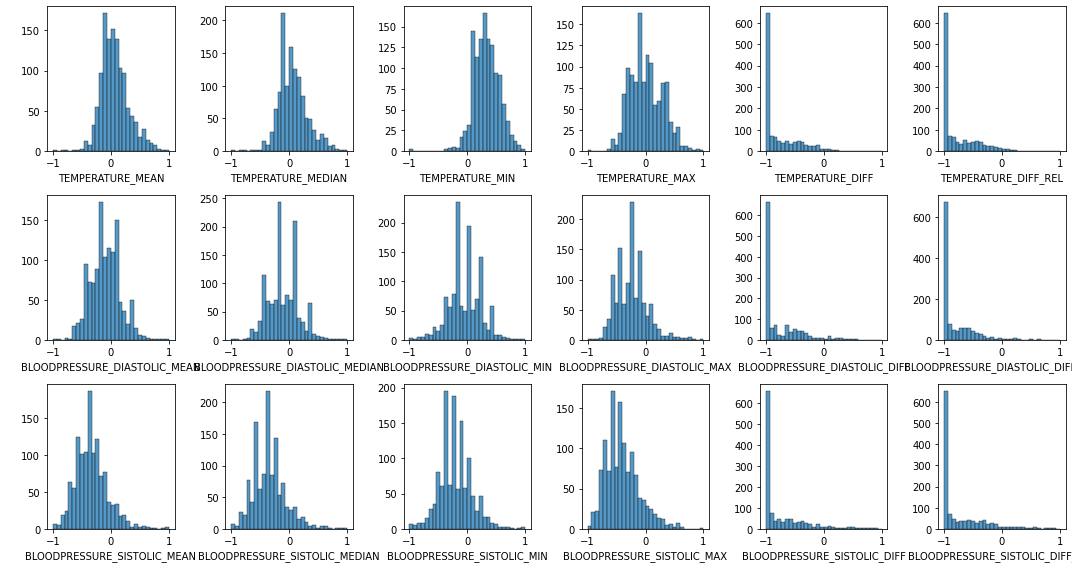

In [187]:
fig, axes = plt.subplots(3, 6, figsize=(15, 8))

for i in range(0, axes.flatten().shape[0]):
    sns.histplot(data=biometrics_df, x=biometrics_df.columns[i], bins=30, ax=axes.flatten()[i])
    axes.flatten()[i].set_ylabel(' ')

plt.tight_layout()

The biometric data distributions are slightly different moving from `MEAN`, `MEDIAN`, `MIN`, `MAX`, `DIFF`, and `DIFF_REL`.
`DIFF` and `DIFF_REL` look like they would be highly correlated. 
The `DIFF` measures will be interesting to explore more because they represent change in a person's condition over the time window. 
For modeling, we may use one stat from `MEAN`, `MEDIAN`, `MIN`, `MAX` and a then one of the `DIFF` stats to reduce collinearity.

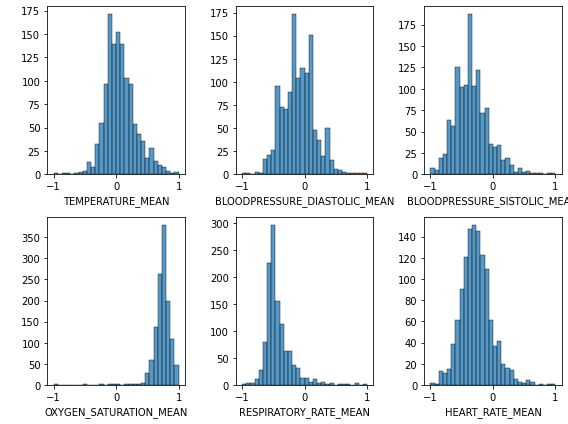

In [190]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

mean_biomet_df = biometrics_df[biometrics_df.columns[biometrics_df.columns.str.contains('MEAN')]]

for i in range(0, axes.flatten().shape[0]):
    sns.histplot(data=mean_biomet_df, x=mean_biomet_df.columns[i], bins=30, ax=axes.flatten()[i])
    axes.flatten()[i].set_ylabel(' ')

plt.tight_layout()

The biometric features are mostly gaussian and appear to have a typical kurtosis (no peaking behavior).
`OXYGEN_SATURATION` is skewed left to negative values and `RESPIRATORY_RATE` is skewed right to positive values.

The overall pattern of differences between biomarker and biometric data is consistent with the description of these features; biometric data can be collected on more occaisions than blood biomarker data. Those differences include:
- more missing values in the biomarker data
  - the data maintainers suggest to use a backfill/forward fill method to fill in the blanks. It's likely a safe assumption as they point out that the feature measures are the same for the intermediate time windows.
- less variance in the statistic features of biomarker data
  - the variance comes from summarizing over the repeated measures and biometric data has multiple repeated measures

##### Modeling decision: missing value imputation
I will use a forward fill for fill from the first to the next measure and then a backward fill to fill the first measure to earlier, unmeasured time windows.

In [1]:
numerics = pd.concat([biomarkers, pd.DataFrame({'name': biometrics})], axis=0)

NameError: name 'pd' is not defined

In [ ]:
numerics_df = pd.DataFrame()

for i in numerics['name']:
    subs_df = data[data.columns[data.columns.str.contains(i)]]
    numerics_df = pd.concat([numerics_df, subs_df], axis=1)

In [ ]:
impute_numerics = numerics_df.merge(
    data['PATIENT_VISIT_IDENTIFIER'],
    left_index=True,
    right_index=True
).groupby('PATIENT_VISIT_IDENTIFIER')\
.ffill()\
.bfill() 

In [ ]:
cols = [x not in impute_numerics.columns for x in data.columns]

data3 = data[data.columns[cols]]\
    .merge(
        impute_numerics,
        left_index=True,
        right_index=True
    )

#### Categorical features

In [8]:
cat_cols = []

for i in data.columns:
    if i not in num_cols:
        cat_cols.append(i)

cat_cols = pd.Series(cat_cols)

cat_cols = cat_cols[~cat_cols.str.contains('DIFF')]

Are disease groupings mutually exclusive? Can group membership span multiple disease groups?

In [64]:
disease_df = data\
    [['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3','DISEASE GROUPING 4', 'DISEASE GROUPING 5']]\
    .assign(
        total = data['DISEASE GROUPING 1'] + data['DISEASE GROUPING 2'] + data['DISEASE GROUPING 3'] + data['DISEASE GROUPING 4'] + data['DISEASE GROUPING 5']
    ).merge(
        data['PATIENT_VISIT_IDENTIFIER'],
        left_index=True,
        right_index=True
    ).groupby('PATIENT_VISIT_IDENTIFIER')\
    .head(1)

In [62]:
disease_df[disease_df['total'] > 1].head(5)

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,total,PATIENT_VISIT_IDENTIFIER
145,0.0,0.0,1.0,1.0,1.0,3.0,29
170,0.0,0.0,1.0,0.0,1.0,2.0,34
220,0.0,0.0,1.0,1.0,0.0,2.0,44
315,0.0,1.0,0.0,1.0,0.0,2.0,63
385,0.0,0.0,1.0,0.0,1.0,2.0,77


In [72]:
data[data['PATIENT_VISIT_IDENTIFIER'] == disease_df[disease_df['total'] > 1].head(1)['PATIENT_VISIT_IDENTIFIER'].values[0]]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
145,29,1,70th,0,0.0,0.0,1.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
146,29,1,70th,0,0.0,0.0,1.0,1.0,1.0,0.0,...,NaN,-1.000000,NaN,NaN,-1.000000,-1.000000,NaN,-1.000000,2-4,0
147,29,1,70th,0,0.0,0.0,1.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,1
148,29,1,70th,0,0.0,0.0,1.0,1.0,1.0,0.0,...,-0.714286,-1.000000,-0.804348,-0.796421,-0.895824,-0.738863,-0.724924,-1.000000,6-12,1
149,29,1,70th,0,0.0,0.0,1.0,1.0,1.0,0.0,...,-0.214286,-0.838384,-0.561437,-0.324974,-0.374046,-0.232258,-0.214286,-0.840206,ABOVE_12,1


The disease groupings are not mutually exclusive. 
I was considering a pie chart for the disease groups but I think bar charts will work for the distribution overview.

##### Distribution plots

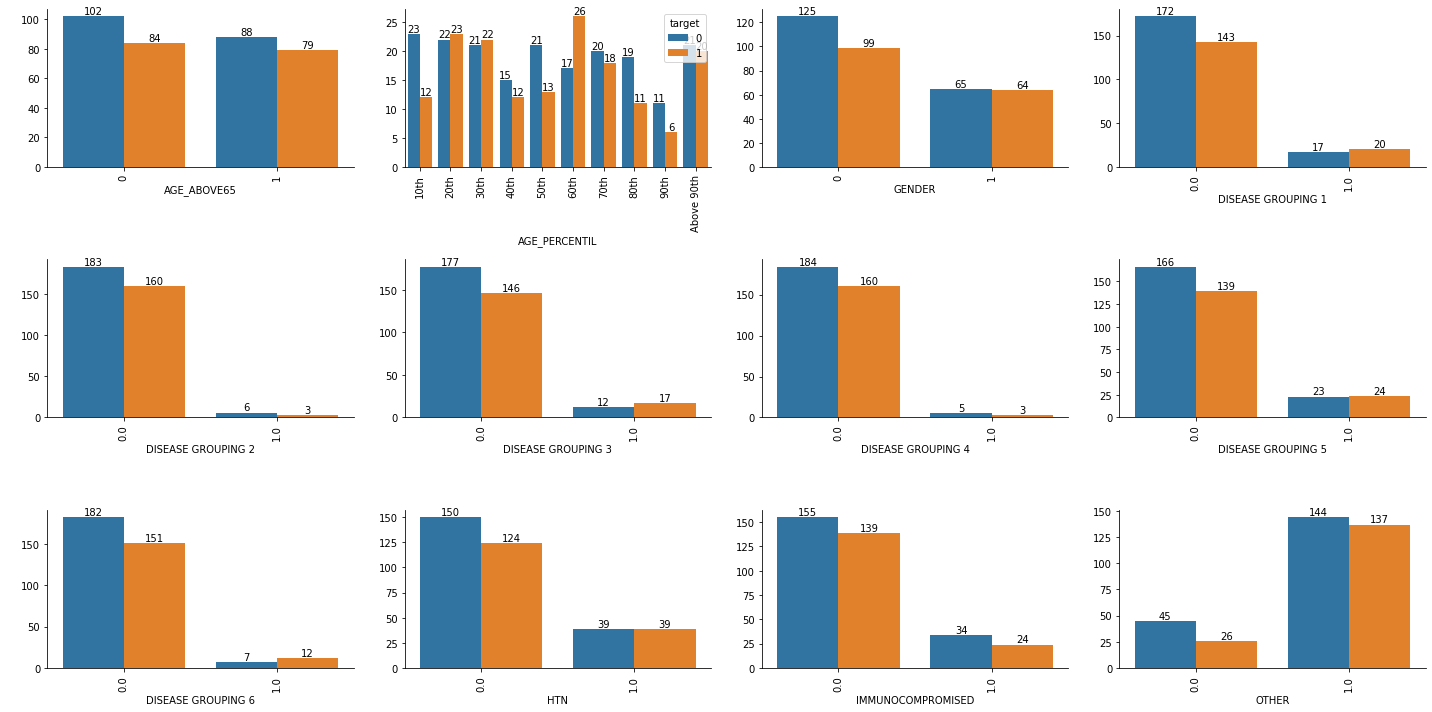

In [65]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

cat_df = data[cat_cols]\
    .merge(
        data2[['PATIENT_VISIT_IDENTIFIER', 'target']],
        left_index=True,
        right_index=True
    )\
    .groupby('PATIENT_VISIT_IDENTIFIER')\
    .head(1)\
    .drop(columns=['WINDOW', 'ICU'])

for i in range(0, axes.flatten().shape[0]):
    if cat_df.columns[i] == 'AGE_PERCENTIL':
        sns.barplot(
            data=pd.DataFrame(cat_df.groupby('target')[cat_df.columns[i]].value_counts()).rename(columns={cat_df.columns[i]: 'count'}).reset_index(), 
            x=cat_df.columns[i],
            y='count',
            hue='target',
            ax=axes.flatten()[i],
            order=['10th', '20th', '30th', '40th', '50th', '60th', '70th', '80th', '90th', 'Above 90th']
        )
        axes.flatten()[i].tick_params(axis='x', labelrotation=90)
        axes.flatten()[i].bar_label(axes.flatten()[i].containers[0])
        axes.flatten()[i].bar_label(axes.flatten()[i].containers[1])
        axes.flatten()[i].set_ylabel(' ')
        sns.despine()
    else:
        sns.barplot(
            data=pd.DataFrame(cat_df.groupby('target')[cat_df.columns[i]].value_counts()).rename(columns={cat_df.columns[i]: 'count'}).reset_index(), 
            x=cat_df.columns[i],
            y='count',
            hue='target',
            ax=axes.flatten()[i]
        )
        axes.flatten()[i].tick_params(axis='x', labelrotation=90)
        axes.flatten()[i].bar_label(axes.flatten()[i].containers[0])
        axes.flatten()[i].bar_label(axes.flatten()[i].containers[1])
        axes.flatten()[i].get_legend().remove()
        axes.flatten()[i].set_ylabel(' ')
        sns.despine()

plt.tight_layout()

These are distribution plots of the people who comprise the dataset.
The `DISEASE GROUPING` features are heavily imbalanced to be absent in people.
`HTN` and `IMUNOCOMPROMISED` are also moslty absent in the people of the dataset.
However, `OTHER` is mostly present.
Moving across groups, the `target` values are somewhat balanced.
However, `target` values are imbalanced for some groups in `AGE_PERCENTIL`:
- there are more negatives in `10th`, `50th`, and `90th`
- there are more positives in `60th`

We need to recode the `AGE_PERCENTIL` feature.

##### Modeling decision: one-hot encoding age groups

In [45]:
age = data['AGE_PERCENTIL']\
    .map({
        '10th': 1,
        '20th': 2,
        '30th': 3,
        '40th': 4,
        '50th': 5,
        '60th': 6,
        '70th': 7,
        '80th': 8,
        '90th': 9,
        'Above 90th': 10
    })

age_df = pd.DataFrame(age).rename(columns={'AGE_PERCENTIL': 'age_group'})

data3 = data3\
    .merge(
        pd.get_dummies(age_df, columns=['age_group'], drop_first=True),
        left_index=True,
        right_index=True
    )\
    .drop(columns=['AGE_PERCENTIL'])

There are 5 missing values for the `DISEASE GROUPING`, `HTN`, `IMMUNOCOMPROMISED`, `OTHER` features.
We can impute them with knn imputer.

In [58]:
data3[data3['DISEASE GROUPING 1'].isna()]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF_REL,age_group_2,age_group_3,age_group_4,age_group_5,age_group_6,age_group_7,age_group_8,age_group_9,age_group_10
995,199,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,0,0,0,0,0,0,0,0,0
996,199,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,0,0,0,0,0,0,0,0,0
997,199,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,0,0,0,0,0,0,0,0,0
998,199,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,0,0,0,0,0,0,0,0,0
999,199,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,0,0,0,0,0,0,0,0,0


These missing values are from a single person.

In [49]:
imputer = KNNImputer(n_neighbors=3)

impute_df = pd.DataFrame(
    imputer.fit_transform(data3.drop(columns='WINDOW')), 
    columns=data3.drop(columns='WINDOW').columns
)

In [62]:
p199 = impute_df[data3['DISEASE GROUPING 1'].isna()].head(6)
p199

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF_REL,age_group_2,age_group_3,age_group_4,age_group_5,age_group_6,age_group_7,age_group_8,age_group_9,age_group_10
995,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The values this person ended up with were negative (0) for all actegories but positive (1) for `OTHER`.

Finally, we can recode the target feature for the `WINDOW` features to include in multivariate EDA and modeling.

In [73]:
data4 = impute_df.copy()

data4 = data4\
    .merge(
        data3[['WINDOW']],
        left_index=True,
        right_index=True
    )

data4 = data4[data4['ICU'] != 1]

data4 = data4.merge(
    target_df[['PATIENT_VISIT_IDENTIFIER', 'lab']],
    on='PATIENT_VISIT_IDENTIFIER'
).rename(columns={'lab': 'target'})

data4['target'] = np.where(data4['target'] == '1_0', 0, 1)
data4.drop(columns=['WINDOW', 'ICU'], inplace=True)

In [74]:
data4.to_csv('./data/data4.csv')

### Multivariate and collinearity analysis

#### Heat map

I have already decided that all of the stat columns should not be used for modeling.
But we can get a view of the collinearity if we leave in all the features.

In [9]:
data = pd.read_csv('./data/data4.csv').drop(columns='Unnamed: 0')

In [ ]:
plt.figure(figsize=(20,26))
sns.heatmap(data.corr())

The heatmap is too large to see the patterns.
I will go ahead and remove columns that might be redundant and try the heatmap again.

In [12]:
# run only ONCE
# remove AGE_PERCENTIL
del cat_cols[1]

In [13]:
biomarkers_mean = biomarkers['name'] + '_MEAN'
biomarkers_mean

biometrics_mean = biometrics + '_MEAN'
biometrics_diff = biometrics + '_DIFF'

feature_list = itertools.chain(
    cat_cols[:-2], 
    ['age_group_' + str(x) for x in range(2,11)], 
    biomarkers_mean,
    biometrics_mean,
    biometrics_diff,
    ['target']
    )

feature_list = list(feature_list)

<AxesSubplot: >

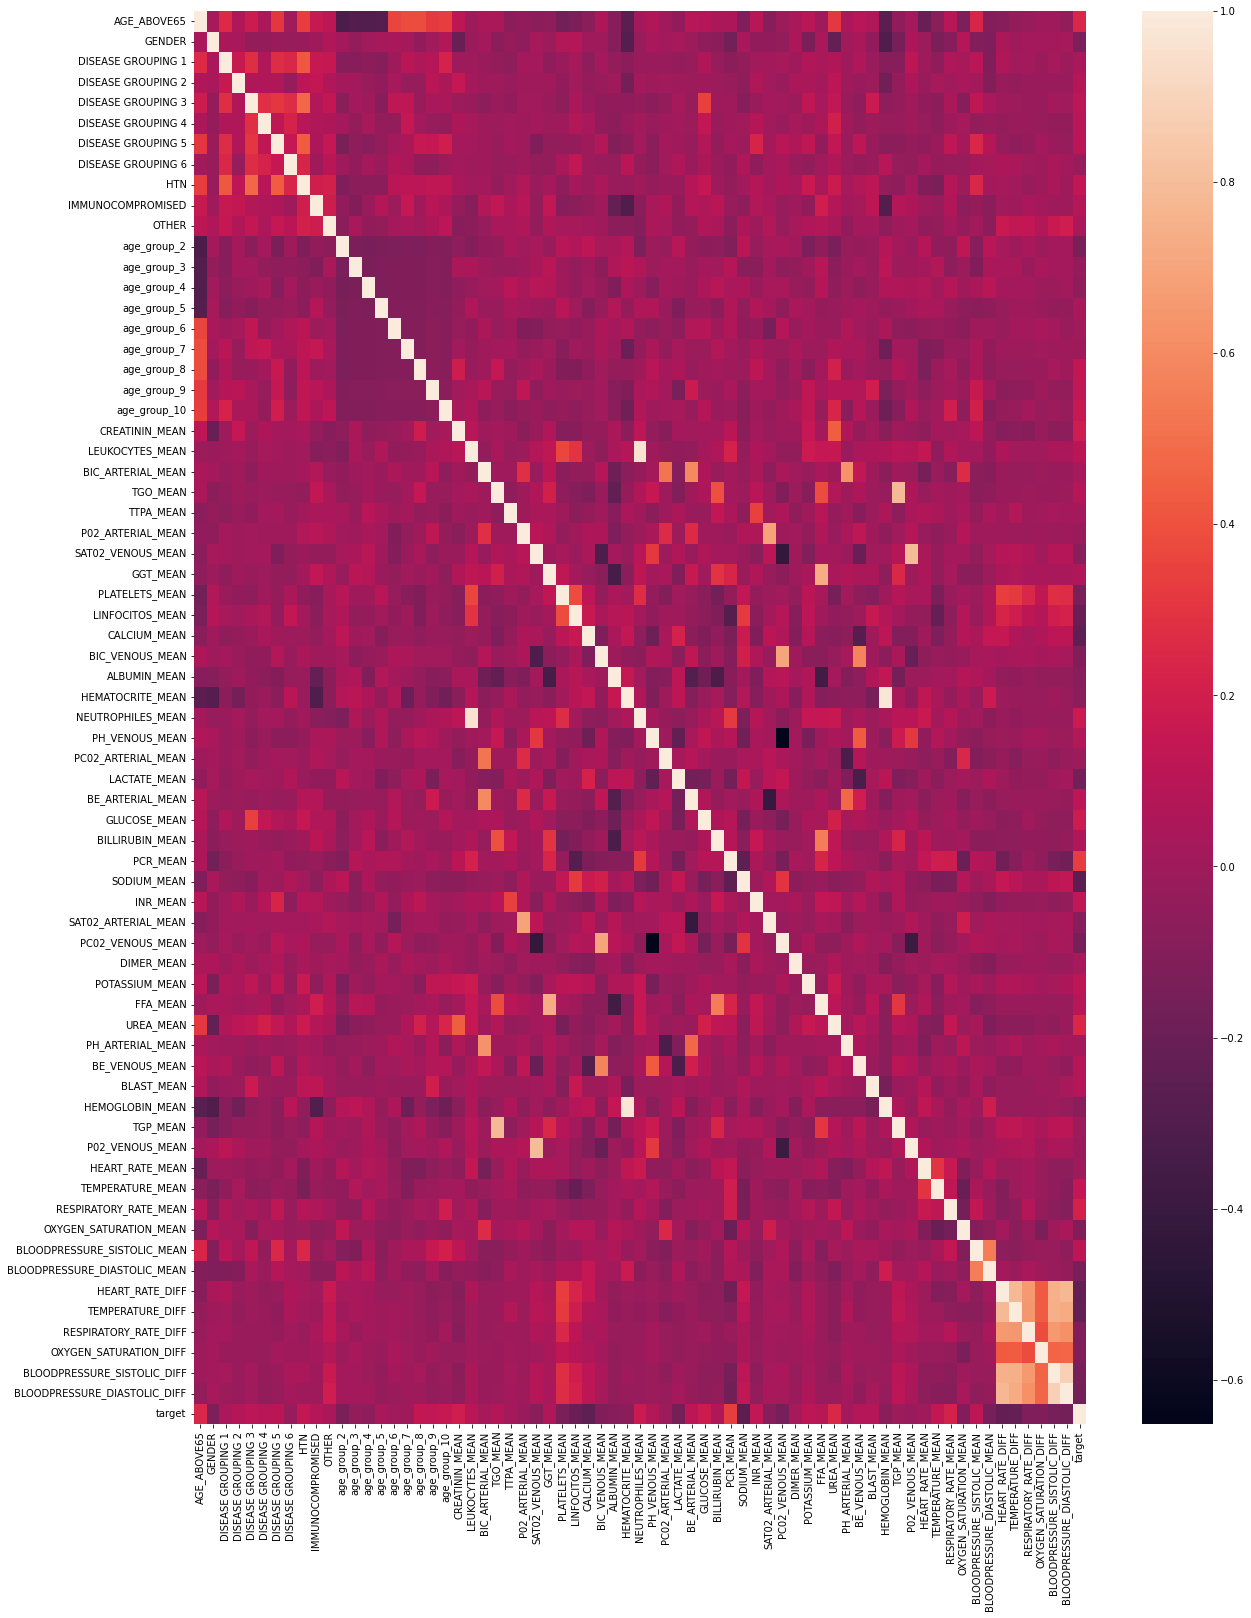

In [14]:
subs_df = data[feature_list]

plt.figure(figsize=(20,26))

sns.heatmap(subs_df.corr())

There are some intense correlations present in the dataset. 
We can drop `AGE_ABOVE65` if we are using the age groups. 

**Positive correlations:**
- The `DIFF` measures are all positively correlated.
  - `PLATELETS` are also positively correlated with `DIFF` features.
- `TGP` and `TGO` are highly correlated. Both are measures of liver function.
- `LEUKOCYTES` and `NEUTROPHILES` are highly correlated. Neutrophils are a type of Leukocyte and there should be a bositive correlation between the counts.
- `HEMATOCRITE` and `HEMOGLOBIN` are both measures of red blood cells and highly correlated.
- `BIC_VENOUS` and `PCO2_VENOUS`. This makes sense because a bicarbonate test is a measure of how much CO~2~ is in blood.
- `PO2_VENOUS` and `SATO2_VENOUS`. The partial pressure of O~2~ is correlated with the saturation of O~2~.
  - `PO2_ARTERIAL` and `SATO2_ARTERIAL`, too.

**Negative correlations:**
- `PH_VENOUS` and `PCO2_VENOUS`
  - to a lesser extent, `PH_ATERIAL` and `PCO2_ARTERIAL`
- `PCO2_VENOUS` and `SATO2_VENOUS`
- `BE_ARTERIAL` and `SATO2_ARTERIAL`

An underlying pattern to correlations are measures that report similar information, measures that report opposite information, and biological location (correlations within the veinous compartment or within the arterial compartment). Interestingly, the same measures across biological compartment are not exceptionally correlated (e.g., `PH_VENOUS` and `PH_ARTERIAL`). I would think because the blood gas composition is functaionally different for transporting blood to and from the tissues and the heart.

In [58]:
df_corr = subs_df.corr()

corr_lst = []
row = 1

for i in df_corr.columns:
    for r in df_corr[i][row:]:
        if abs(r) > 0.7 and r!= 1:
            corr_lst.append((
                i, 
                df_corr[i].index[df_corr[i] == r][0],
                r
            ))
    row += 1

In [59]:
corr_lst

[('LEUKOCYTES_MEAN', 'NEUTROPHILES_MEAN', 0.9556611489586683),
 ('TGO_MEAN', 'TGP_MEAN', 0.7817746290395046),
 ('SAT02_VENOUS_MEAN', 'P02_VENOUS_MEAN', 0.787785502758845),
 ('GGT_MEAN', 'FFA_MEAN', 0.7347762352218433),
 ('HEMATOCRITE_MEAN', 'HEMOGLOBIN_MEAN', 0.9752041857685837),
 ('HEART_RATE_DIFF', 'TEMPERATURE_DIFF', 0.7824237255487085),
 ('HEART_RATE_DIFF', 'BLOODPRESSURE_SISTOLIC_DIFF', 0.750946639850154),
 ('HEART_RATE_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF', 0.7750769642317766),
 ('TEMPERATURE_DIFF', 'BLOODPRESSURE_SISTOLIC_DIFF', 0.7474386750122085),
 ('TEMPERATURE_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF', 0.7233846341288858),
 ('BLOODPRESSURE_SISTOLIC_DIFF',
  'BLOODPRESSURE_DIASTOLIC_DIFF',
  0.8811643411062234)]

#### Modeling decision: dropping highly correlated columns

All of the strong correlations (>0.7) are positive.
We can see that the `DIFF` features are highly correlated.
None of those features is expecially correlated with `target` outcome on its own (see the heat map above)
From the correlations list (`corr_lst`), we can decide which columns to drop.
I think correlation strength, redundancy, measurement collection ease and specificity would be useful to consider here.
- The lowest of the `DIFF` correlations is `('TEMPERATURE_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF', 0.7233846341288858)` so we can decide to **drop** `HEART_RATE_DIFF` and `BLOODPRESSURE_SISTOLIC_DIFF`.
- Neutrophils are a white blood cell subtype of leukocytes so we can **drop** `LEUKOCYTES_MEAN` 
- Lets **drop** `TGP_MEAN`. Both tests measure similar function of the liver and TGO seems to be more correlated with `target`.
- `GGT` and `FFA` tests are dissimilar enough and the correlation relatively less strong so these can stay in the dataset for now.
- Hemoglobin is a more direct measure of the oxygen-carrying ability of red-blood cells so we can **drop** `HEMATOCRITE_MEAN`.


In [62]:
drop_cols = ['AGE_ABOVE65', 'HEART_RATE_DIFF', 'BLOODPRESSURE_SISTOLIC_DIFF', 'LEUKOCYTES_MEAN', 'TGP_MEAN', 'HEMATOCRITE_MEAN']

subs2_df = subs_df.drop(columns=drop_cols)

<AxesSubplot: >

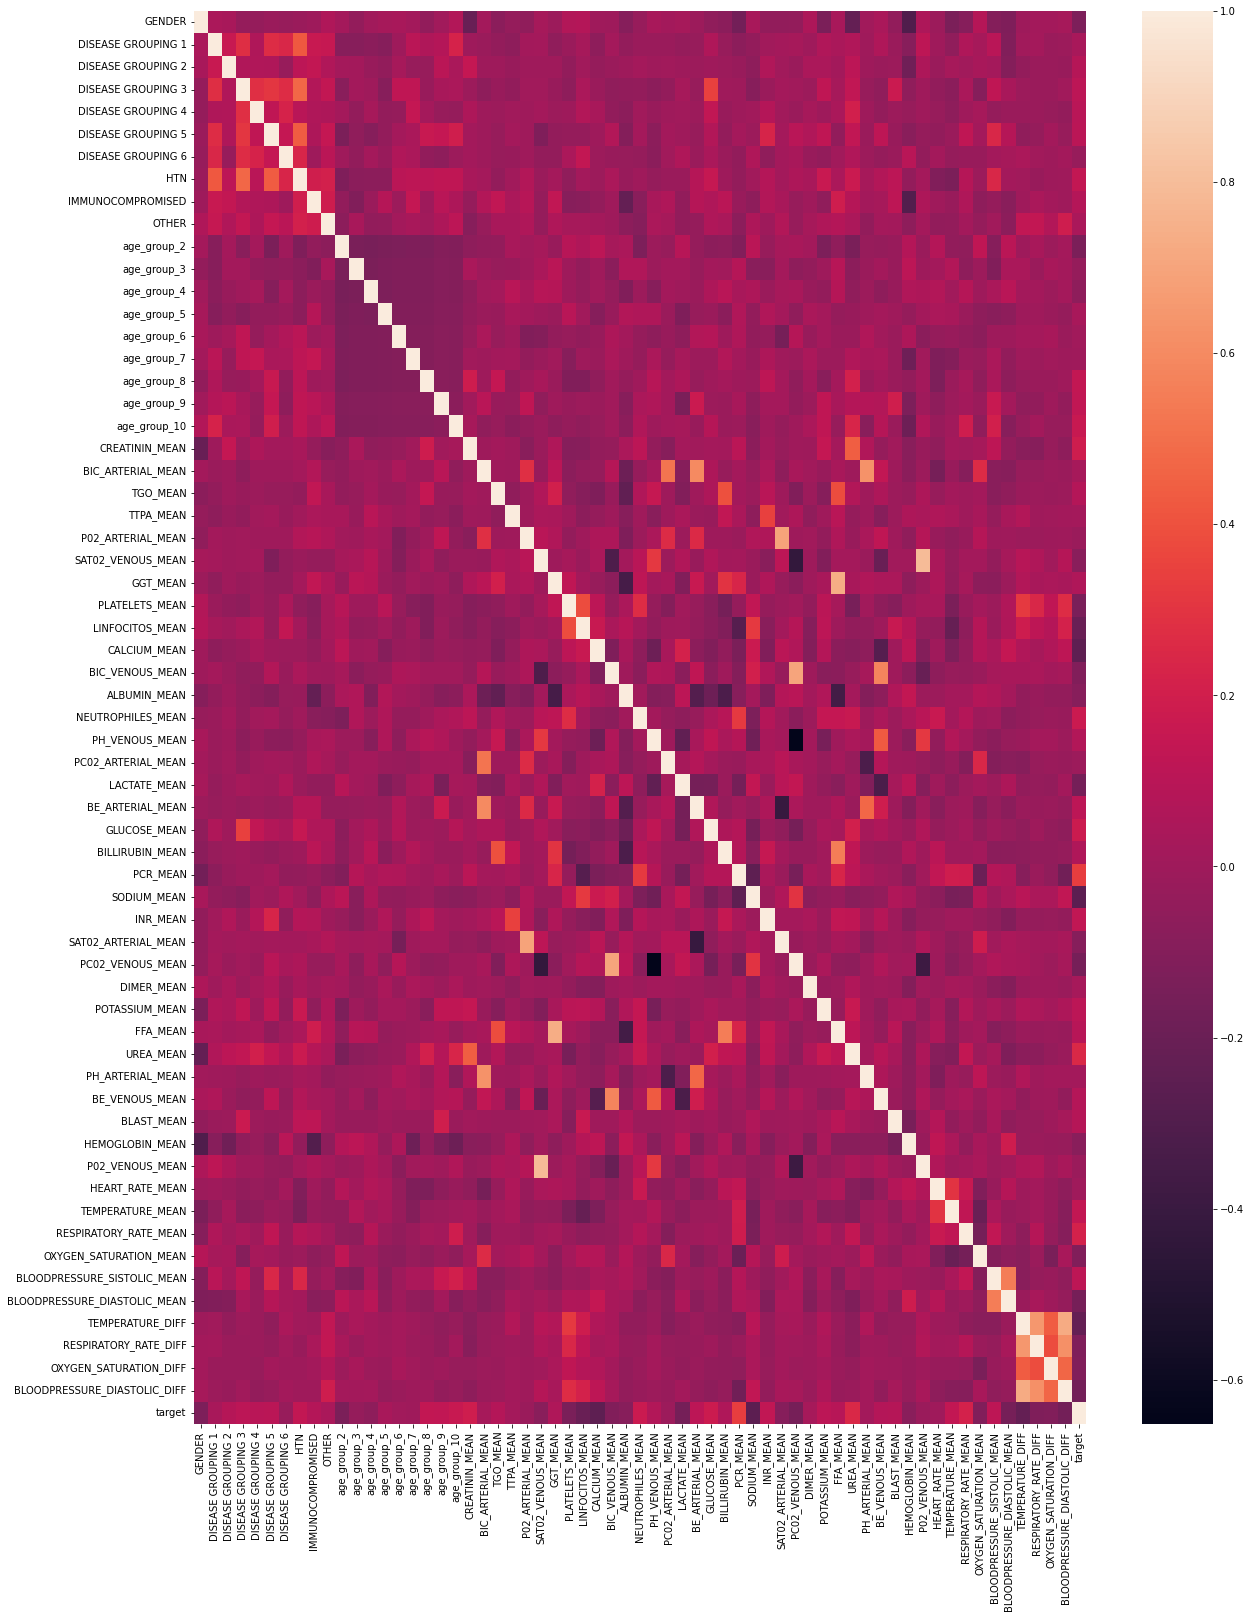

In [105]:
plt.figure(figsize=(20,26))

sns.heatmap(subs2_df.corr())

#### Pair plots and scatter plots

`HEMOGLOBIN`, `SODIUM`, and `PLATELETS` had (visually) wider distributions.
We might be able to see some subgroups emerge through variable interaction with these biomarker features.
However, there were other featrues more correlated with the `target`, like `NEUTROPHILS`, `PCR`, `CALCIUM`, and `RESPIRATORY RATE`.

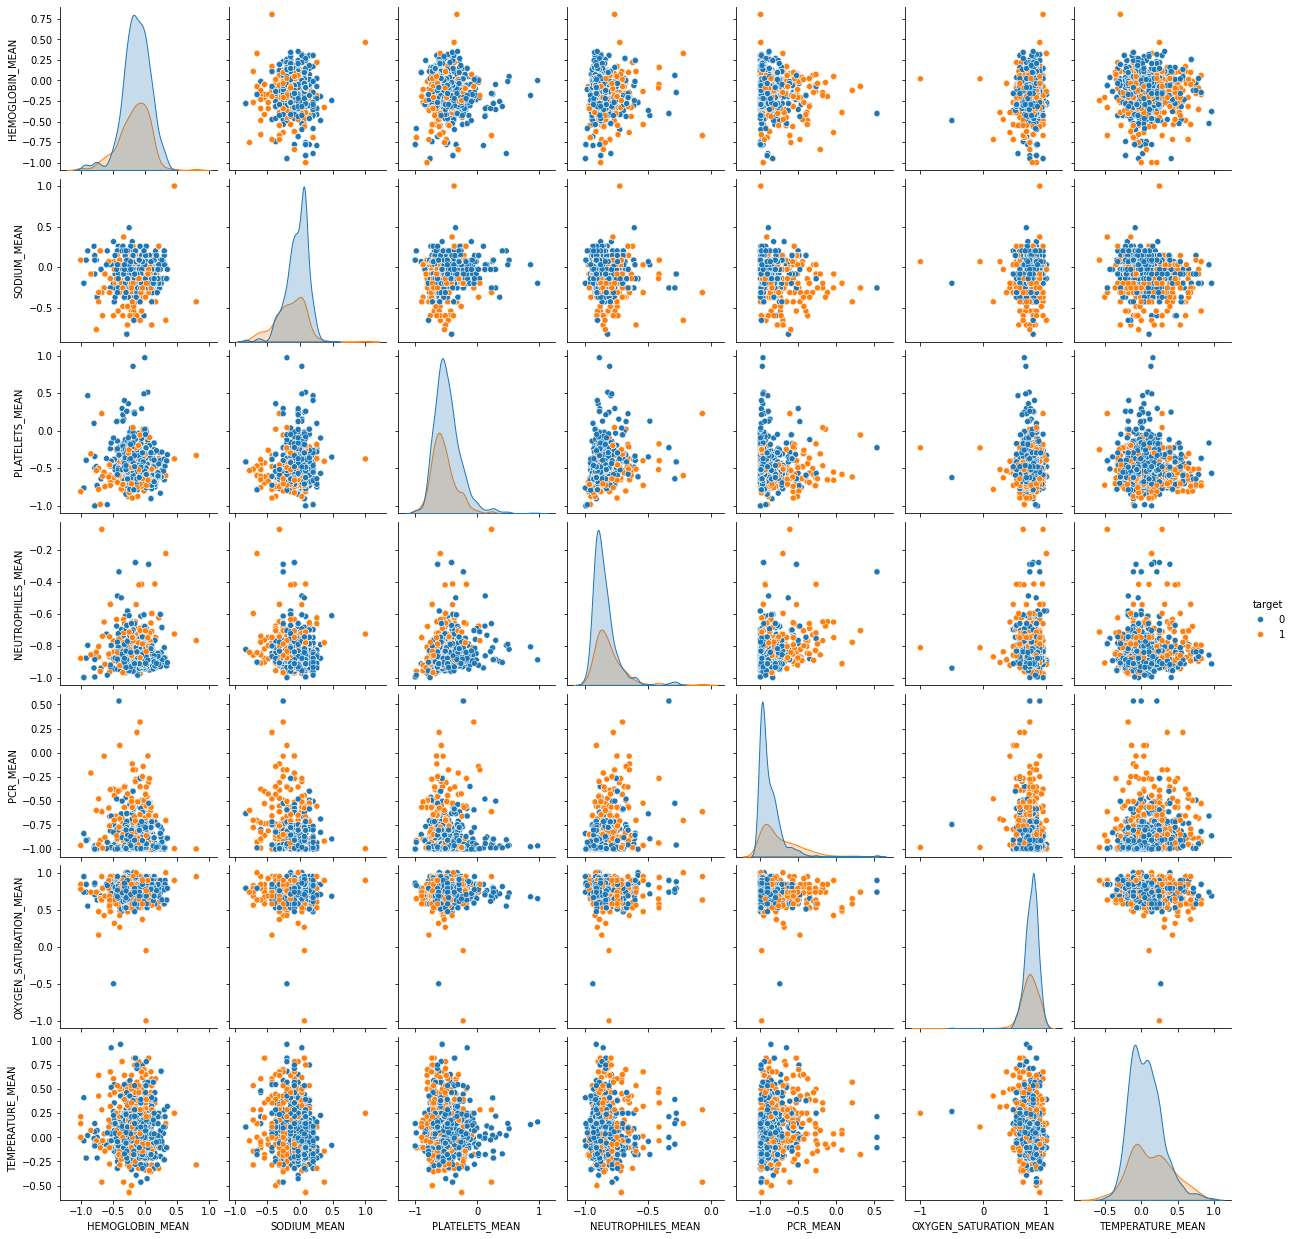

In [104]:
meas = [
    'HEMOGLOBIN_MEAN', 
    'SODIUM_MEAN', 
    'PLATELETS_MEAN', 
    'NEUTROPHILES_MEAN',
    'PCR_MEAN',
    'OXYGEN_SATURATION_MEAN',
    'TEMPERATURE_MEAN',
    'target'
]

sns.pairplot(data=subs2_df[meas], hue='target')

We can see that no single metric predicts the target. 
`SODIUM` and `PCR`, individually, are two of the most correlated features with the `target` but individually cannot be used for predictions.
Some 2D scatterplots suggest there might be subgroups but these are nowhere near resolved.
- this is especially the case with `SODIUM` and `PCR`. The **negative** correlation of `SODIUM` and `target`, together with the **positive** correlation of `PCR` and `target`, begins to separate the `target` values.

Considering the interaction of multiple dimensions would likely improve prediction chances. We can attempt glimpsing multi-dimensional patterns by grouping plots.

##### Scatterplots by age group

In [ ]:
age_df = subs2_df\
    .assign(
        age_group = subs2_df['age_group_2'] + subs2_df['age_group_3'] + subs2_df['age_group_4'] + subs2_df['age_group_5'] + 
       subs2_df['age_group_6'] + subs2_df['age_group_7'] + subs2_df['age_group_8'] + subs2_df['age_group_9'] + 
       subs2_df['age_group_10']
    )


In [142]:
age_mask = [((age_df['age_group'] == 0) | (age_df['age_group_2'] == 1) | (age_df['age_group_3'] == 1)),
 ((age_df['age_group_4'] == 1) | (age_df['age_group_5'] == 1) | (age_df['age_group_6'] == 1)),
 ((age_df['age_group_7'] == 1) | (age_df['age_group_8'] == 1) | (age_df['age_group_9'] == 1) | (age_df['age_group_10'] == 1))]

age_title = [
  "Age < 40",
  "40 <= Age < 70",
  "Age >= 70"
]

plot_feats = [
  'NEUTROPHILES_MEAN',
  'RESPIRATORY_RATE_MEAN',
  'SODIUM_MEAN',
  'PCR_MEAN'
]

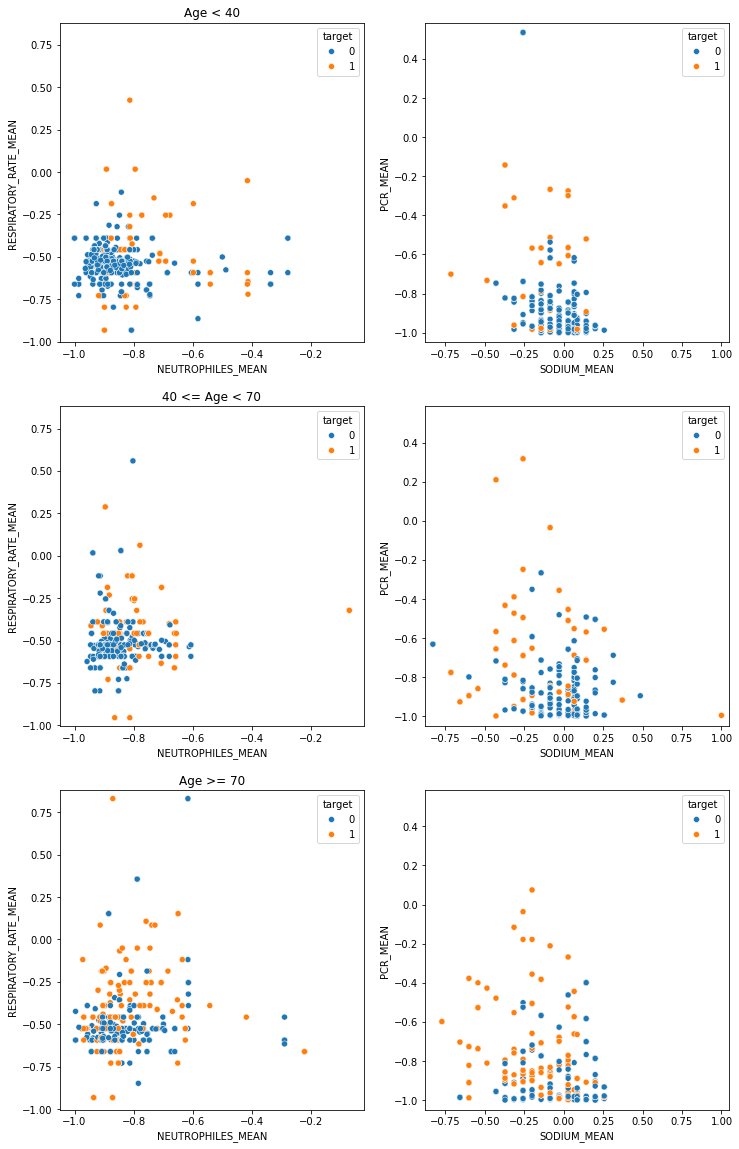

In [143]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 20))

for i in range(0, 3):
    sns.scatterplot(
        data=age_df[age_mask[i]],
        x=plot_feats[0],
        y=plot_feats[1],
        hue='target',
        ax=axes[i][0]
    )
    axes[i][0].set_title(age_title[i])
    axes[i][0].set_xlim(age_df[plot_feats[0]].min() - 0.05, age_df[plot_feats[0]].max() + 0.05)
    axes[i][0].set_ylim(age_df[plot_feats[1]].min() - 0.05, age_df[plot_feats[1]].max() + 0.05)
    sns.scatterplot(
        data=age_df[age_mask[i]],
        x=plot_feats[2],
        y=plot_feats[3],
        hue='target',
        ax=axes[i][1]
    )
    axes[i][1].set_xlim(age_df[plot_feats[2]].min() - 0.05, age_df[plot_feats[2]].max() + 0.05)
    axes[i][1].set_ylim(age_df[plot_feats[3]].min() - 0.05, age_df[plot_feats[3]].max() + 0.05)


There may be a slight visual distinction present in these plots but this distinction becomes less pronounced with increasing age.

##### Scatterplots along comorbidity statuses

In [144]:
comorbid_mask = [
    ((age_df['DISEASE GROUPING 1'] == 0) |\
     (age_df['DISEASE GROUPING 2'] == 0) |\
     (age_df['DISEASE GROUPING 3'] == 0) |\
     (age_df['DISEASE GROUPING 4'] == 0) |\
     (age_df['DISEASE GROUPING 5'] == 0) |\
     (age_df['DISEASE GROUPING 6'] == 0) |\
     (age_df['HTN'] == 0) |\
     (age_df['IMMUNOCOMPROMISED'] == 0)),
    ((age_df['DISEASE GROUPING 1'] == 1) |\
     (age_df['DISEASE GROUPING 2'] == 1) |\
     (age_df['DISEASE GROUPING 3'] == 1) |\
     (age_df['DISEASE GROUPING 4'] == 1) |\
     (age_df['DISEASE GROUPING 5'] == 1) |\
     (age_df['DISEASE GROUPING 6'] == 1) |\
     (age_df['HTN'] == 1) |\
     (age_df['IMMUNOCOMPROMISED'] == 1))
]

comorbid_title = [
  "No comorbidities available",
  "Comorbidities present"
]

plot_feats = [
    'NEUTROPHILES_MEAN',
    'RESPIRATORY_RATE_MEAN',
    'SODIUM_MEAN',
    'PCR_MEAN'
]

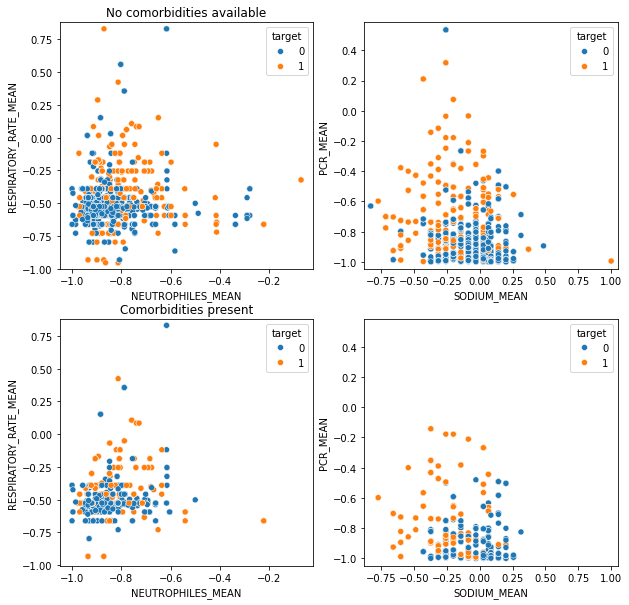

In [145]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i in range(0, 2):
    sns.scatterplot(
        data=age_df[comorbid_mask[i]],
        x=plot_feats[0],
        y=plot_feats[1],
        hue='target',
        ax=axes[i][0]

    )
    axes[i][0].set_title(comorbid_title[i])
    axes[i][0].set_xlim(age_df[plot_feats[0]].min() - 0.05, age_df[plot_feats[0]].max() + 0.05)
    axes[i][0].set_ylim(age_df[plot_feats[1]].min() - 0.05, age_df[plot_feats[1]].max() + 0.05)
    sns.scatterplot(
        data=age_df[comorbid_mask[i]],
        x=plot_feats[2],
        y=plot_feats[3],
        hue='target',
        ax=axes[i][1]
    )
    axes[i][1].set_xlim(age_df[plot_feats[2]].min() - 0.05, age_df[plot_feats[2]].max() + 0.05)
    axes[i][1].set_ylim(age_df[plot_feats[3]].min() - 0.05, age_df[plot_feats[3]].max() + 0.05)

Similar patterns in the numeric features are present along a comordibity partition.
The patterns are not visually differnt by comorbidity status.
No matter how we manually partition the data, the decision boundary does not seem to change and there is a large overlap among `target` groups.
We can consider this a prediction use case where machine learning would improve our predictions over the dataset.

In [146]:
subs2_df.to_csv('data/mldata1.csv')

# Machine learning models

## Train, test, validation split (70:15:15)

This is a standard data split for machine learning workflows.

In [4]:
data = pd.read_csv('data/mldata1.csv').drop(columns='Unnamed: 0')
X = data.drop(columns='target')
y = data['target']

In [5]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [6]:
y_res.value_counts()

0    460
1    460
Name: target, dtype: int64

In [41]:
X_train = X_res.sample(frac=0.7, random_state=42)
y_train = y_res[X_train.index]

In [42]:
X_testval = X_res.drop(X_train.index)
y_testval = y_res[X_testval.index]

X_val = X_testval.sample(frac=0.5, random_state=42)
y_val = y_testval[X_val.index]

X_test = X_testval.drop(X_val.index)
y_test = y_testval[X_test.index]

In [43]:
y_train.value_counts(), y_test.value_counts(),  y_val.value_counts()

(0    335
 1    309
 Name: target, dtype: int64,
 1    78
 0    60
 Name: target, dtype: int64,
 1    73
 0    65
 Name: target, dtype: int64)

## Base models

Here, I'm assessing standard supervised classification machine learning models.

### Logistic regression

In [44]:
log_model = LogisticRegression(
    class_weight='balanced', 
    random_state=42, 
    max_iter=1000
)

log_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [45]:
y_pred = log_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75        60
           1       0.82      0.77      0.79        78

    accuracy                           0.78       138
   macro avg       0.77      0.78      0.77       138
weighted avg       0.78      0.78      0.78       138



In [54]:
cv_score = cross_val_score(
    estimator=log_model, 
    X=X_train, 
    y=y_train, 
    cv=5,
    scoring=roc_auc_scorer
)


In [55]:
f'{cv_score.mean():.2f} \u00B1 {cv_score.std():.3f}'

'0.84 ± 0.017'

Throughout modeling: 
- I used the area under the recieving operating curve as an unbalanced metric of model performance.
Unbalanced meaning, we want to accurately predict which people need the ICU **AND** which people do not because we need to help the people who need it without overcrowding the ICU.
- I used the **standard deviation** of the cross validation score to serve as a measure of model overfitting.

The average accuracy for a base logistic regression model is ~0.80. 
There is a **sizeable variance** (~2%) in model accuracy depending upon the training dataset.

### Decision tree

In [64]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [65]:
y_pred = dt_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86        60
           1       0.88      0.92      0.90        78

    accuracy                           0.88       138
   macro avg       0.89      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138



In [66]:
cv_score = cross_val_score(
    estimator=dt_model, 
    X=X_train, 
    y=y_train, 
    cv=5,
    scoring=roc_auc_scorer
)


In [67]:
f'{cv_score.mean():.2f} \u00B1 {cv_score.std():.3f}'

'0.85 ± 0.029'

A base decision tree model might have more overall accuracy but there is an even **larger variance** (~3) for prediction accuracy by cross validation.
Model variation is typical for untuned decision trees.

### Random forest

In [70]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [71]:
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        60
           1       0.96      0.97      0.97        78

    accuracy                           0.96       138
   macro avg       0.96      0.96      0.96       138
weighted avg       0.96      0.96      0.96       138



In [72]:
cv_score = cross_val_score(
    estimator=rf_model, 
    X=X_train, 
    y=y_train, 
    cv=5,
    scoring=roc_auc_scorer
)


In [73]:
f'{cv_score.mean():.2f} \u00B1 {cv_score.std():.3f}'

'0.97 ± 0.012'

This is impressive accuracy for the base random forest model.
The model variance is ~0.1, the lowest of the base models.
This indicates the random forest model can already generalize across slightly different training sets.

I will be tuning a random forest model to arrive at a final ML model to predict ICU need among people hospitalized for Covid19.

## Random forest model tuning

### Feature selection

In [ ]:
for i in range(0, X_train.shape[1]):
    print(i)

In [90]:
cv_mean = []
cv_std = []
k = []

for i in range(1, X_train.shape[1]):

    selector = SelectKBest(
        score_func=f_classif,
        k=i
    )

    best_features = selector.fit_transform(X_train, y_train)

    cv_score = cross_val_score(
        estimator=rf_model, 
        X=best_features, 
        y=y_train, 
        cv=5,
        scoring=roc_auc_scorer
    )

    print(i)
    k.append(i)
    cv_mean.append(cv_score.mean())
    cv_std.append(cv_score.std())

In [91]:
feature_df = pd.DataFrame({
    'k': k,
    'cv_mean': cv_mean,
    'cv_std': cv_std
})

In [95]:
feature_df['cv_mean_max'] = feature_df['cv_mean'] / feature_df['cv_mean'].max()
feature_df['cv_std_max'] = feature_df['cv_std'] / feature_df['cv_std'].max()

What is `k` for the highest model accuracy?

In [101]:
feature_df[feature_df['cv_mean_max'] == 1]

,k,cv_mean,cv_std,cv_mean_max,cv_std_max
47,48,0.978627,0.012083,1.0,0.237971


What is `k` for the lowest model standard deviation?

In [102]:
feature_df[feature_df['cv_std_max'] == feature_df['cv_std_max'].min()]

,k,cv_mean,cv_std,cv_mean_max,cv_std_max
49,50,0.974267,0.010141,0.995545,0.19972


Visuals for context near `k` values near 50.

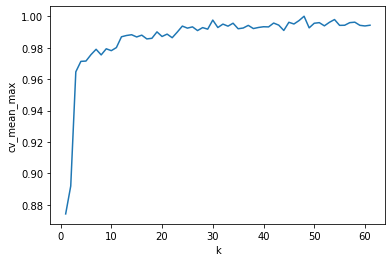

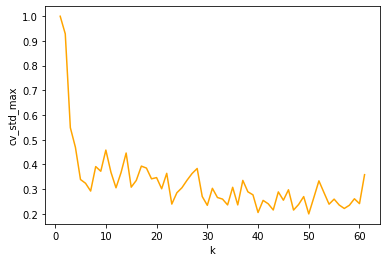

In [99]:
sns.lineplot(data=feature_df, x='k', y='cv_mean_max')
plt.show()
sns.lineplot(data=feature_df, x='k', y='cv_std_max', color='orange')
plt.show()

Mean model accuracy (blue line) is somewhat stable for `k>30`. 
Model accuracy std (orange line) is much more vaired for `k>30`.

Moving from `k` = 48 to 50:
- there is some loss in model accuracy (~0.005% from the maximum mean)
- but the improvement in model std is ~3.5%  from the maximum std.

Considering these changes from `k` might not yeild much for the performance of the final model.

However, for hyperparameter tuning, I will use the features from `k=50`.

In [ ]:
feature_df

### Hyperparameter tuning

In [117]:
rf_model = RandomForestClassifier(
    max_features=50, 
    random_state=42, 
    class_weight='balanced'
)

In [110]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 6]
}

In [118]:
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    cv=5, 
    verbose=2, 
    refit=True,
    scoring=log_losser
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=150; total time=   3.1s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=150; total time=   1.8s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=150; total time=   1.9s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=150; total time=   1.7s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=150; total time=   1.9s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END .max_depth=5, min_samples_split=2, n_e

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features=50,
                                              random_state=42),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200]},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
             verbose=2)

In [120]:
print(grid_search.best_params_)

{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}


For hyperparameter tuning, I used the `log_loss` scoring function to select best parameters for the model. 
Log loss is a common metric applied to binary classification.
The metric considers predicted values and actual values for each of the two outcomes and minimizes that difference.
I used it here because we need a model that is accurate at predicting both 'Yes' and 'No', and other metrics like accuracy score would likely select parameters that would overtrain the final model.

## Final models

### Final model 1: `max_features = 50`
Implementing the knowledge of `k=50` into the call to `RandomForestClassifier` with the `max_features` parameter.

In [121]:
rf_model_final = RandomForestClassifier(
    max_features=50, 
    random_state=42, 
    class_weight='balanced',
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split']
)

In [122]:
rf_model_final.fit(X_train, y_train)

y_pred = rf_model_final.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92        60
           1       0.94      0.95      0.94        78

    accuracy                           0.93       138
   macro avg       0.93      0.93      0.93       138
weighted avg       0.93      0.93      0.93       138



In [123]:
cv_score = cross_val_score(
    estimator=rf_model_final, 
    X=X_train, 
    y=y_train, 
    cv=5,
    scoring=roc_auc_scorer
)

In [124]:
f'{cv_score.mean():.2f} \u00B1 {cv_score.std():.3f}'

'0.96 ± 0.020'

In [125]:
y_pred = rf_model_final.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        65
           1       0.94      0.89      0.92        73

    accuracy                           0.91       138
   macro avg       0.91      0.91      0.91       138
weighted avg       0.91      0.91      0.91       138



### Final model 2: 62 features
Returning to the features before selection by `SelectKBest()`.

In [139]:
rf_model_final2 = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced',
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split']
)

In [140]:
rf_model_final2.fit(X_train, y_train)

y_pred = rf_model_final2.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        60
           1       0.96      0.97      0.97        78

    accuracy                           0.96       138
   macro avg       0.96      0.96      0.96       138
weighted avg       0.96      0.96      0.96       138



In [141]:
cv_score = cross_val_score(
    estimator=rf_model_final2, 
    X=X_train, 
    y=y_train, 
    cv=5,
    scoring=roc_auc_scorer
)

In [142]:
f'{cv_score.mean():.2f} \u00B1 {cv_score.std():.3f}'

'0.98 ± 0.013'

In [143]:
y_pred = rf_model_final2.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        65
           1       0.99      0.96      0.97        73

    accuracy                           0.97       138
   macro avg       0.97      0.97      0.97       138
weighted avg       0.97      0.97      0.97       138



### Final model 3: `k=50` features
Using the 50 features selected by `SelectKBest()`.

In [147]:
selector = SelectKBest(
    score_func=f_classif,
    k=50
)

best_features = selector.fit_transform(X_train, y_train)

best_features_df = pd.DataFrame(data=best_features, columns=selector.get_feature_names_out())

In [148]:
rf_model_final3 = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced',
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split']
)

In [149]:
rf_model_final3.fit(best_features_df, y_train)

y_pred = rf_model_final3.predict(X_test[selector.get_feature_names_out()])

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        60
           1       0.97      0.99      0.98        78

    accuracy                           0.98       138
   macro avg       0.98      0.98      0.98       138
weighted avg       0.98      0.98      0.98       138



In [152]:
cv_score3 = cross_val_score(
    estimator=rf_model_final3, 
    X=best_features_df, 
    y=y_train, 
    cv=5,
    scoring=roc_auc_scorer
)

In [153]:
f'{cv_score3.mean():.2f} \u00B1 {cv_score3.std():.3f}'

'0.98 ± 0.013'

In [154]:
y_pred = rf_model_final3.predict(X_val[selector.get_feature_names_out()])

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        65
           1       0.97      0.96      0.97        73

    accuracy                           0.96       138
   macro avg       0.96      0.96      0.96       138
weighted avg       0.96      0.96      0.96       138



### Interpretation

Setting `max_features=50` was not a great way to implement the knowledge of the `SelectKBest()` function. This is because `max_features` randomly considers 50 features when looking for the best split while `SelectKBest()` selects the best columns before starting the algorithm.

Using 50 features versus 62 features did not substantially change the model accuracy much.
It seems that having 62 features might have slightly improved generalizeability to the validation dataset.

We can consider the final model 2/3 accuracy of **0.96** to be a realistic estimate for the model generalizeability.

In [162]:
import skops.io as sio
sio.dump(rf_model_final3, './model_files/rf_model_final3.skops')